## Merchant Insights 🔍

In this notebook we find insights about the merchants that are interested in forming partnership with us and analyse those that may be "interesting" to take different aspects into consideration when making our selection.

In [11]:
# import libraries and constants
import sys
sys.path.append('../scripts/utils')
from constants import *

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import pandas as pd
import matplotlib.pyplot as plt

In [12]:
# create a spark session 
spark = (
    SparkSession.builder.appName("MAST30034 Project 2")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config('spark.driver.memory', '4g')
    .config('spark.executor.memory', '2g')
    .getOrCreate()
)

In [13]:
fraud_data = pd.read_pickle(f"{CURATED_DATA}consumer_fraud_probability.pkl")
fraud_data.head(5)

,user_id,order_datetime,fraud_probability
0,6228,2021-12-19,97.629808
1,21419,2021-12-10,99.247380
2,5606,2021-10-17,84.058250
3,3101,2021-04-17,91.421921
4,22239,2021-10-19,94.703425


In [14]:
# read data
tbl_merchants = pd.read_pickle(f"{CURATED_DATA}tbl_merchants.pkl")
tbl_consumers = pd.read_pickle(f"{CURATED_DATA}tbl_consumer.pkl")
fraud_data = pd.read_pickle(f"{CURATED_DATA}consumer_fraud_probability.pkl")
transactions = spark.read.parquet(f"{TRANSACTION_DATA}")

# join to get transactions with merchants and consumers details
transactions_joined = transactions.join(spark.createDataFrame(tbl_consumers), on="user_id", how="inner") 
transactions_joined = transactions_joined.withColumnRenamed("name", "con_name")
transactions_joined = transactions_joined.join(spark.createDataFrame(tbl_merchants), on="merchant_abn", how="inner")
transactions_joined = transactions_joined.withColumnRenamed("name", "mer_name")
transactions_joined = transactions_joined.join(spark.createDataFrame(fraud_data), on=["user_id", "order_datetime"], how='left')
transactions_joined = transactions_joined.fillna({'fraud_probability': 0})
transactions_joined = transactions_joined.withColumnRenamed("fraud_probability", "con_fp")

transactions_joined.limit(5)

23/10/20 16:30:17 WARN TaskSetManager: Stage 57 contains a task of very large size (3029 KiB). The maximum recommended task size is 1000 KiB.
23/10/20 16:30:24 WARN TaskSetManager: Stage 68 contains a task of very large size (3029 KiB). The maximum recommended task size is 1000 KiB.


user_id,order_datetime,merchant_abn,dollar_value,order_id,con_name,state,postcode,gender,consumer_id,has_title,mer_name,products,revenue_levels,take_rate,category,con_fp
7,2022-07-21,35909341340,158.6024,a816889d-61d3-4a4...,Andrea Jones,QLD,4606,Female,511685,false,Arcu Sed Eu Incor...,computer programm...,b,4.8,computer programm...,0.0
7,2022-07-21,89726005175,72.9463,863d70d8-cb7e-48c...,Andrea Jones,QLD,4606,Female,511685,false,Est Nunc Consulting,tent and awning s...,a,6.01,tent and awning s...,0.0
7,2022-09-13,72472909171,54.1891,33cd08e3-80c2-483...,Andrea Jones,QLD,4606,Female,511685,false,Nullam Consulting,digital goods: bo...,a,6.33,digital goods: books,0.0
7,2022-07-18,72472909171,24.4676,e43fc398-36ff-422...,Andrea Jones,QLD,4606,Female,511685,false,Nullam Consulting,digital goods: bo...,a,6.33,digital goods: books,0.0
7,2022-06-16,71528203369,80.0923,8d7c7d5e-0e5d-422...,Andrea Jones,QLD,4606,Female,511685,false,Ipsum Primis Asso...,"watch, clock, and...",a,6.94,watch,0.0


In [15]:
# read data

abs_df = pd.read_pickle(f"{RAW_DATA}abs_table_1_postcode.pkl")

# join to get transactions and consumer demographic details

# convert string into float
abs_df = abs_df.astype(float)

# change a column name 'POA_code' into 'postcode'
abs_df.rename(columns={'POA_code': 'postcode'}, inplace=True)

# convert Pandas dataframe into pyspark dataframe 
abs_sdf = spark.createDataFrame(abs_df)

# combine ABS data into transactions_consumer data by postcode 
transactions_abs = transactions_joined.join(abs_sdf, on='postcode', how='left')

transactions_abs.limit(5)

23/10/20 16:30:30 WARN TaskSetManager: Stage 79 contains a task of very large size (3029 KiB). The maximum recommended task size is 1000 KiB.
23/10/20 16:30:36 WARN TaskSetManager: Stage 93 contains a task of very large size (3029 KiB). The maximum recommended task size is 1000 KiB.


postcode,user_id,order_datetime,merchant_abn,dollar_value,order_id,con_name,state,gender,consumer_id,has_title,mer_name,products,revenue_levels,take_rate,category,con_fp,relative_SE_dis_score,relative_SE_dis_decile,relative_SE_ad_dis_score,relative_SE_ad_dis_decile,economic_resources_score,economic_resources_decile,education_occupation_score,education_occupation_decile,population
4606,7,2022-07-21,35909341340,158.6024,a816889d-61d3-4a4...,Andrea Jones,QLD,Female,511685,false,Arcu Sed Eu Incor...,computer programm...,b,4.8,computer programm...,0.0,906.86486191,1.0,880.70731846,1.0,936.84974278,2.0,887.0140924,1.0,2399.0
4606,7,2022-07-21,89726005175,72.9463,863d70d8-cb7e-48c...,Andrea Jones,QLD,Female,511685,false,Est Nunc Consulting,tent and awning s...,a,6.01,tent and awning s...,0.0,906.86486191,1.0,880.70731846,1.0,936.84974278,2.0,887.0140924,1.0,2399.0
4606,7,2022-09-13,72472909171,54.1891,33cd08e3-80c2-483...,Andrea Jones,QLD,Female,511685,false,Nullam Consulting,digital goods: bo...,a,6.33,digital goods: books,0.0,906.86486191,1.0,880.70731846,1.0,936.84974278,2.0,887.0140924,1.0,2399.0
4606,7,2022-07-18,72472909171,24.4676,e43fc398-36ff-422...,Andrea Jones,QLD,Female,511685,false,Nullam Consulting,digital goods: bo...,a,6.33,digital goods: books,0.0,906.86486191,1.0,880.70731846,1.0,936.84974278,2.0,887.0140924,1.0,2399.0
4606,7,2022-06-16,71528203369,80.0923,8d7c7d5e-0e5d-422...,Andrea Jones,QLD,Female,511685,false,Ipsum Primis Asso...,"watch, clock, and...",a,6.94,watch,0.0,906.86486191,1.0,880.70731846,1.0,936.84974278,2.0,887.0140924,1.0,2399.0


### 1. Merchants with very small number of consumers but make large purchases

In [16]:
# find merchants where the difference between total spending and number of consumers is large

merchant_sdf = transactions_joined.groupBy('merchant_abn').agg(
    F.countDistinct('user_id').alias('num_users'),
    F.sum('dollar_value').alias('total_spending'),
    (F.sum('dollar_value') / F.countDistinct('user_id')).alias('avg_spending_per_user')
)
large_ratio = merchant_sdf.sort(F.col('avg_spending_per_user').desc())
large_ratio.limit(5)

23/10/20 16:30:41 WARN TaskSetManager: Stage 107 contains a task of very large size (3029 KiB). The maximum recommended task size is 1000 KiB.
23/10/20 16:30:46 WARN TaskSetManager: Stage 122 contains a task of very large size (3029 KiB). The maximum recommended task size is 1000 KiB.


merchant_abn,num_users,total_spending,avg_spending_per_user
42461534060,2,50232.5563,25116.27815
10404542215,1,22773.9753,22773.9753
28311306642,2,43994.4543,21997.22715
62688594508,1,21112.5679,21112.5679
28385291716,5,99793.4307,19958.686139999998


These are the merchant ABNs that may not have a large number of customers, but each customer's spending is significant. They may have high customer loyalty, however relying on a small group of customers can be risky. If one or more of these customers stop purchasing, it can significantly impact the merchant's revenue.

### 2. Merchants with Large Consumer Transactions but Low Economic Resources Score

In [17]:
# find ratio of average customer spending to their economic resources score, high ratio means spending is big compared to income/housing score

abs_sdf = transactions_abs.groupBy('merchant_abn').agg(
    F.avg('dollar_value').alias('avg_customer_spending'),
    F.avg('economic_resources_score').alias('avg_economic_resources'),
    (F.avg('dollar_value') / F.sum('economic_resources_score')).alias('ratio_spending_to_ers')
)

filtered_abs_sdf = abs_sdf.filter(~F.isnan('ratio_spending_to_ers'))
low_ers = filtered_abs_sdf.sort(F.col('ratio_spending_to_ers').desc())
low_ers.limit(5)

23/10/20 16:30:52 WARN TaskSetManager: Stage 137 contains a task of very large size (3029 KiB). The maximum recommended task size is 1000 KiB.
23/10/20 16:30:59 WARN TaskSetManager: Stage 155 contains a task of very large size (3029 KiB). The maximum recommended task size is 1000 KiB.


merchant_abn,avg_customer_spending,avg_economic_resources,ratio_spending_to_ers
62688594508,21112.5679,749.3676996,28.17384297624455
42461534060,25116.27815,938.66870912,26.75734037576096
10404542215,22773.9753,1006.4571748,22.627863231762017
28311306642,21997.22715,1037.5200848,21.201736209511882
64094501963,18365.7611,932.61770893,19.69270036816177


Consumers with low average economic resources score may indicate: they are more likely to have lower incomes, or they are paying lower rent for their housing. High spending by consumers with low economic resources may suggest that they are living beyond their means or relying on credit, which could lead to financial instability and difficulty in repaying debts, and could pose a potential risk for our company if we decide to onboard these merchants.

### 3. Some merchants have a high number of returning customers, some have none

In [18]:
# find number of customers in each merchant that make more than one purchase

user_purchases = transactions_joined.groupBy('merchant_abn', 'user_id').agg(
    F.count('order_id').alias('num_purchases')
)

merchant_sdf = user_purchases.groupBy('merchant_abn').agg(
    F.countDistinct(
        F.when(F.col('num_purchases') > 1, F.col('user_id'))
    ).alias('returning_customers')
)
high_returning_customers = merchant_sdf.sort(F.col('returning_customers').desc())
high_returning_customers.limit(5)

23/10/20 16:31:07 WARN TaskSetManager: Stage 173 contains a task of very large size (3029 KiB). The maximum recommended task size is 1000 KiB.
23/10/20 16:31:18 WARN TaskSetManager: Stage 192 contains a task of very large size (3029 KiB). The maximum recommended task size is 1000 KiB.


merchant_abn,returning_customers
86578477987,24079
64203420245,24077
24852446429,24076
49891706470,24072
46804135891,24067


In [19]:
no_returning_cust = (merchant_sdf.where(F.col("returning_customers")==0)).count()
total_merchant = merchant_sdf.count()
print(f"{no_returning_cust/total_merchant * 100:.2f}% of merchants have 0 returning customers")

23/10/20 16:31:26 WARN TaskSetManager: Stage 211 contains a task of very large size (3029 KiB). The maximum recommended task size is 1000 KiB.
23/10/20 16:31:31 WARN TaskSetManager: Stage 235 contains a task of very large size (3029 KiB). The maximum recommended task size is 1000 KiB.


34.54% of merchants have 0 returning customers


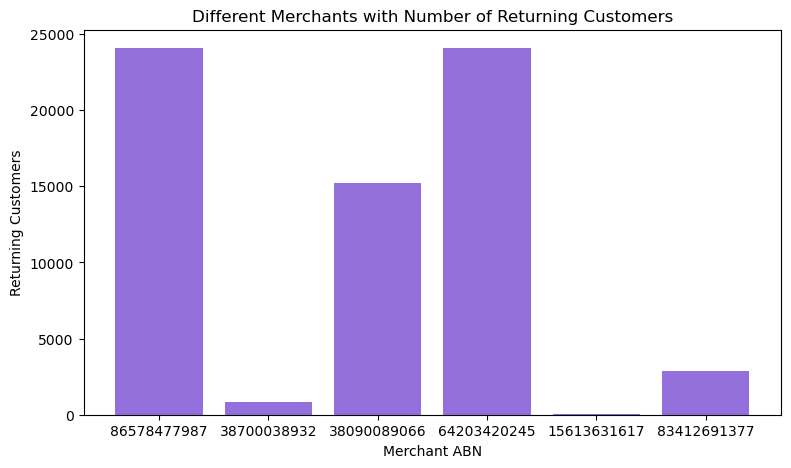

In [20]:
# plotting different merchants with their number of returning customers

merchant_abn = ["86578477987", "38700038932", "38090089066", "64203420245", "15613631617", "83412691377"]
returning_customers = [24079, 863, 15218, 24077, 67, 2902]

plt.figure(figsize=(9, 5))
plt.bar(merchant_abn, returning_customers, color='mediumpurple')
plt.xlabel('Merchant ABN')
plt.ylabel('Returning Customers')
plt.title('Different Merchants with Number of Returning Customers')
plt.savefig(f'{MERCHANT_INSIGHTS}returning_customers.jpg', dpi=300)
plt.show()

Merchants with a substantial number of returning customers signifies a strong customer base and a steady stream of revenue which is highly beneficial for our company.

### 4. Merchants that are exposed to most of the regions across Australia

In [21]:
# find merchants that have highest number of different postal codes exposed to in their transactions

merchant_sdf = transactions_joined.groupBy("merchant_abn").agg(
    F.countDistinct("postcode").alias("num_postcodes_covered")
)

distinct_postcodes = transactions_joined.select('postcode').distinct()
print("Number of distinct postcodes:", distinct_postcodes.count())

high_num_postcodes = merchant_sdf.sort(F.col('num_postcodes_covered').desc())
low_num_postcodes = merchant_sdf.sort(F.col('num_postcodes_covered').asc())

high_num_postcodes.limit(5)

23/10/20 16:31:34 WARN TaskSetManager: Stage 251 contains a task of very large size (3029 KiB). The maximum recommended task size is 1000 KiB.


Number of distinct postcodes: 3165


23/10/20 16:31:39 WARN TaskSetManager: Stage 268 contains a task of very large size (3029 KiB). The maximum recommended task size is 1000 KiB.
23/10/20 16:31:48 WARN TaskSetManager: Stage 283 contains a task of very large size (3029 KiB). The maximum recommended task size is 1000 KiB.


merchant_abn,num_postcodes_covered
45629217853,3165
64403598239,3165
86578477987,3165
89726005175,3165
63290521567,3165


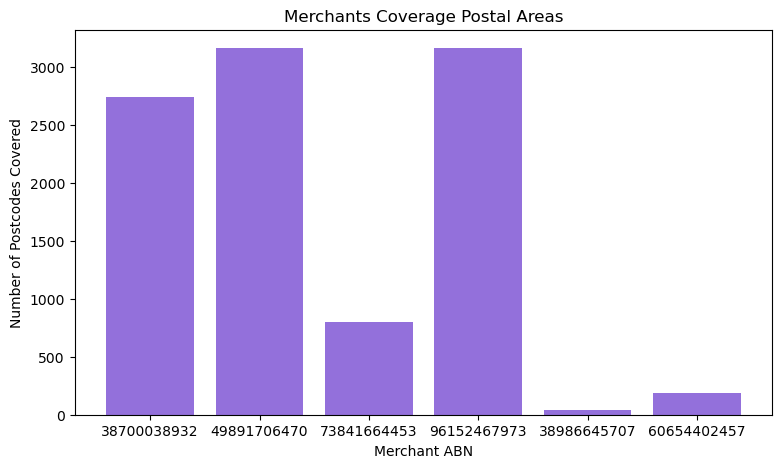

In [22]:
# plotting

merchant_abn = ["38700038932", "49891706470", "73841664453", "96152467973", "38986645707", "60654402457"]
num_postcodes = [2740, 3165, 803, 3164, 41, 190]

plt.figure(figsize=(9, 5))
plt.bar(merchant_abn, num_postcodes, color='mediumpurple')
plt.xlabel('Merchant ABN')
plt.ylabel('Number of Postcodes Covered')
plt.title('Merchants Coverage Postal Areas')
plt.savefig(f'{MERCHANT_INSIGHTS}coverage_postal_areas.jpg', dpi=300)
plt.show()

There are nearly 3,333 postal areas in Australia, therefore these merchants have very high exposure and presence of transactions in almost all regions across the country.

### 5. Merchants with customers from low populated areas

In [23]:
# find merchants that have consumers in areas with population less than 1000

minimum_population = transactions_abs.agg(F.min('population')).collect()[0][0]
print("Minimum Population:", minimum_population)

filtered_merchants = transactions_abs.filter(transactions_abs['population'] <= minimum_population )
merchant_sdf = filtered_merchants.select('merchant_abn').distinct()

merchant_sdf.limit(5)

23/10/20 16:31:57 WARN TaskSetManager: Stage 309 contains a task of very large size (3029 KiB). The maximum recommended task size is 1000 KiB.


Minimum Population: 4.0


23/10/20 16:32:05 WARN TaskSetManager: Stage 332 contains a task of very large size (3029 KiB). The maximum recommended task size is 1000 KiB.
23/10/20 16:32:15 WARN TaskSetManager: Stage 361 contains a task of very large size (3029 KiB). The maximum recommended task size is 1000 KiB.


merchant_abn
83412691377
35344855546
73841664453
73256306726
38700038932


Onboarding merchants that are exposed to low-populated areas can have both advantages and disadvantages, as it can help expand our market reach but they may have lower transaction volumes, however serving remote areas could including higher delivery costs which can affect our revenue potential.

### 6. Merchants with large consumer base but high average consumer fraud rates

In [24]:
# find average consumer fraud of each merchant

merchant_sdf = transactions_joined.groupBy('merchant_abn').agg(
    F.countDistinct('user_id').alias('num_users'),
    F.avg('con_fp').alias('avg_con_fp')
)
consumer_base_threshold = 4000
fraud_rate_threshold = 0.5

merchant_sdf = merchant_sdf.filter(
    (F.col('num_users') >= consumer_base_threshold) &
    (F.col('avg_con_fp') >= fraud_rate_threshold)
)
merchant_sdf.limit(10)

23/10/20 16:32:22 WARN TaskSetManager: Stage 384 contains a task of very large size (3029 KiB). The maximum recommended task size is 1000 KiB.
23/10/20 16:32:27 WARN TaskSetManager: Stage 399 contains a task of very large size (3029 KiB). The maximum recommended task size is 1000 KiB.


merchant_abn,num_users,avg_con_fp
38700038932,6170,0.6120601736546061
82368304209,4649,1.6185477573651799
70009327857,4454,0.7693712327413672
79827781481,4314,1.8077180172652767
75454398468,5320,0.6805023907149388
87084550311,4366,0.6708320553370155


While a large consumer base can offer significant opportunities, it would be useful to acknowledge that this also comes with increased exposure to potential fraudulent activities and associated risks. 

### 7. Merchants have different revenue growths throughout the year

In [25]:
# find revenue growth rate by subtracting the revenue and divide by revenue of the past year

transactions_joined = transactions_joined.withColumn('year', F.year(F.col('order_datetime')))

merchant_sdf_2021 = transactions_joined.filter(transactions_joined.year == 2021).groupBy('merchant_abn').agg(
    F.sum('dollar_value').alias('total_revenue_2021')
)

merchant_sdf_2022 = transactions_joined.filter(transactions_joined.year == 2022).groupBy('merchant_abn').agg(
    F.sum('dollar_value').alias('total_revenue_2022')
)

merged_merchants = merchant_sdf_2021.join(merchant_sdf_2022, 'merchant_abn', 'inner')
merged_merchants = merged_merchants.withColumn('revenue_growth_rate', (F.col('total_revenue_2022') - F.col('total_revenue_2021')) / F.col('total_revenue_2021')
)

merchant_revenue_growth = merged_merchants.sort(F.col('revenue_growth_rate').desc())

merchant_revenue_growth.limit(5)

23/10/20 16:32:31 WARN TaskSetManager: Stage 414 contains a task of very large size (3029 KiB). The maximum recommended task size is 1000 KiB.
23/10/20 16:32:35 WARN TaskSetManager: Stage 438 contains a task of very large size (3029 KiB). The maximum recommended task size is 1000 KiB.


merchant_abn,total_revenue_2021,total_revenue_2022,revenue_growth_rate
58680132589,1308.8413,27009.118000000002,19.635899860433806
27518736748,733.8138,13640.6738,17.588739813832884
52524795452,2168.0386,26371.2757,11.163655988412753
35235320738,3694.3124,41890.4634,10.339177325664176
31416331470,4219.505300000001,42171.0557,8.994312769319187


In [26]:
merchant_no_grow = merged_merchants.sort(F.col('revenue_growth_rate').asc())
merchant_no_grow.limit(5)

23/10/20 16:32:39 WARN TaskSetManager: Stage 462 contains a task of very large size (3029 KiB). The maximum recommended task size is 1000 KiB.
23/10/20 16:32:43 WARN TaskSetManager: Stage 486 contains a task of very large size (3029 KiB). The maximum recommended task size is 1000 KiB.


merchant_abn,total_revenue_2021,total_revenue_2022,revenue_growth_rate
51267358936,20653.337900000002,1275.3104,-0.9382516082303578
93263170091,14795.5772,1698.6867,-0.8851895619185441
89575340835,15194.0033,1820.4360000000001,-0.8801872051719246
85117752663,73370.40100000001,8990.054,-0.8774702894154823
25781502446,33299.0426,4269.7183,-0.8717765447106278


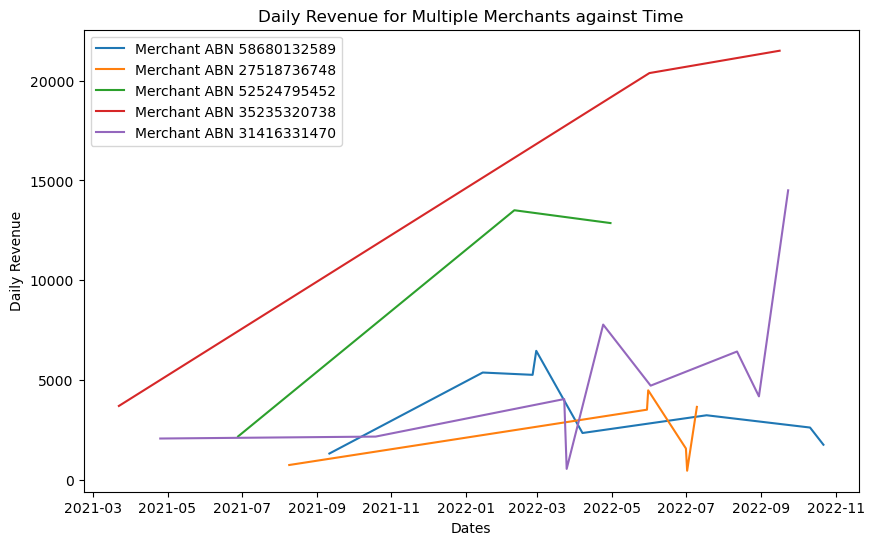

In [27]:
# visualize revenue growth for highest growth merchants

merchant_abns = ["58680132589", "27518736748", "52524795452", "35235320738", "31416331470"] 

merged_df = pd.DataFrame()

plt.figure(figsize=(10, 6))
plt.xlabel("Dates")
plt.ylabel("Daily Revenue")
plt.title("Daily Revenue for Multiple Merchants against Time")

for merchant_abn in merchant_abns:
    merchant_growth = transactions.filter(transactions.merchant_abn == merchant_abn).groupBy("order_datetime").agg(
        F.sum("dollar_value").alias("total_revenue")
    )

    merchant_growth = merchant_growth.withColumn("order_date", F.to_date("order_datetime"))

    merchant_df = merchant_growth.toPandas()

    merchant_df = merchant_df.sort_values(by="order_date")

    plt.plot(merchant_df["order_date"], merchant_df["total_revenue"], label=f"Merchant ABN {merchant_abn}")
    plt.legend()

plt.savefig(f'{MERCHANT_INSIGHTS}daily_revenue_one.jpg', dpi=300)
plt.show()

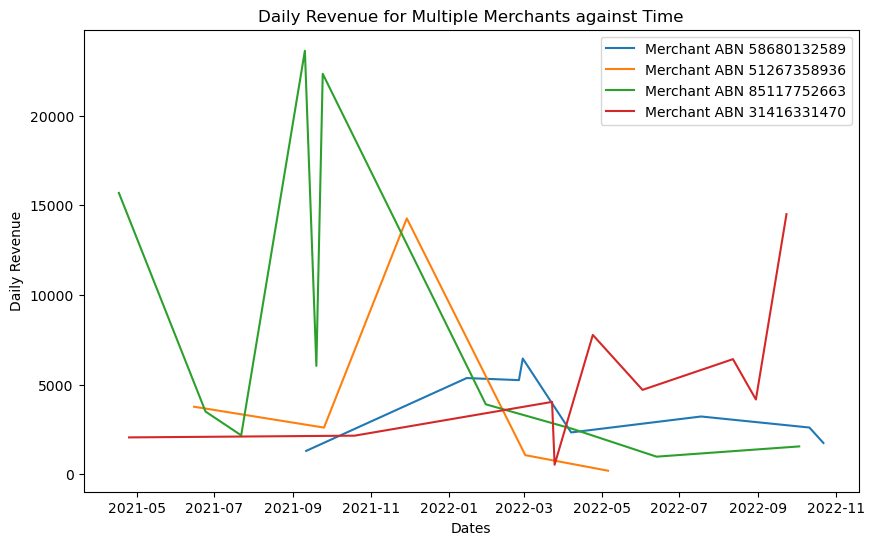

In [28]:
# visualize revenue growth for random merchants

merchant_abns = ["58680132589", "51267358936", "85117752663", "31416331470"] 

merged_df = pd.DataFrame()

plt.figure(figsize=(10, 6))
plt.xlabel("Dates")
plt.ylabel("Daily Revenue")
plt.title("Daily Revenue for Multiple Merchants against Time")

for merchant_abn in merchant_abns:
    merchant_growth = transactions.filter(transactions.merchant_abn == merchant_abn).groupBy("order_datetime").agg(
        F.sum("dollar_value").alias("total_revenue")
    )

    merchant_growth = merchant_growth.withColumn("order_date", F.to_date("order_datetime"))

    merchant_df = merchant_growth.toPandas()

    merchant_df = merchant_df.sort_values(by="order_date")

    plt.plot(merchant_df["order_date"], merchant_df["total_revenue"], label=f"Merchant ABN {merchant_abn}")
    plt.legend()

plt.savefig(f'{MERCHANT_INSIGHTS}daily_revenue_two.jpg', dpi=300)
plt.show()


Merchant ABN 58680132589 has a quite steady expansion indicating a positive response from customers and potential for long-term collaboration. On the other hand, merchants like ABN 85117752663, which exhibit inconsistent and fluctuating revenue, may require closer monitoring and support to understand the underlying factors causing these fluctuations. Merchants like ABN 31416331470, with low but stable revenue, can be reliable partners, especially if they cater to niche markets or offer products with consistent demand. 